In [1]:
import importlib
import ismrmrd
import rtoml
import os
from scipy.io import loadmat
from scipy.signal.windows import tukey
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import ifftshift
import mrdhelper
from constants import PILOTTONE_WAVEFORM_ID
# Read config
with open('config.toml', 'r') as cf:
    cfg = rtoml.load(cf)

DATA_ROOT = cfg['DATA_ROOT']
DATA_DIR = cfg['data_folder']
raw_file = cfg['raw_file']
remove_os = cfg['saving']['remove_os']
f_pt = cfg['pilottone']['pt_freq']
ismrmrd_data_fullpath, ismrmrd_noise_fullpath = mrdhelper.siemens_mrd_finder(DATA_ROOT, DATA_DIR, raw_file)

In [2]:
# Read the data in
print(f'Reading {ismrmrd_data_fullpath}...')
with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:

    n_acq = dset.number_of_acquisitions()
    print(f'There are {n_acq} acquisitions in the file. Reading...')

    acq_list = []
    for ii in range(n_acq):
        acq_list.append(dset.read_acquisition(ii))

    n_wf = dset.number_of_waveforms()
    print(f'There are {n_wf} waveforms in the dataset. Reading...')

    wf_list = []
    for ii in range(n_wf):
        wf_list.append(dset.read_waveform(ii))
    
    hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())

# get the k-space trajectory based on the metadata hash.
traj_name = hdr.userParameters.userParameterString[1].value

# load the .mat file containing the trajectory
traj = loadmat(os.path.join(DATA_ROOT, DATA_DIR, traj_name), squeeze_me=True)

n_unique_angles = int(traj['param']['repetitions'])

kx = traj['kx'][:,:]
ky = traj['ky'][:,:]
dt = float(traj['param']['dt'])
msize = int(10 * traj['param']['fov'] / traj['param']['spatial_resolution'])
pre_discard = int(traj['param']['pre_discard'])
w = traj['w']

# Convert raw data and trajectory into convenient arrays
ktraj = np.stack((kx, -ky), axis=2)
# find max ktraj value
kmax = np.max(np.abs(kx + 1j * ky))
# swap 0 and 1 axes to make repetitions the first axis (repetitions, interleaves, 2)
ktraj = np.swapaxes(ktraj, 0, 1)
ktraj = 0.5 * (ktraj / kmax) * msize

data = [arm.data[:,:] for arm in acq_list]
dcf = np.tile(w[None, :], (n_acq, 1))
coord = [ktraj[ii%n_unique_angles,:,:] for ii in range(n_acq)]

data = np.array(data)
data = np.transpose(data, axes=(2, 0, 1))
coord = np.array(coord, dtype=np.float32)
coord = np.transpose(coord, axes=(2, 1, 0))


Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5/meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz.h5...
There are 14400 acquisitions in the file. Reading...
There are 4430 waveforms in the dataset. Reading...


Coils to be used as sniffers: ['Spine_18:1:S4T' 'Spine_18:1:S4S' 'Spine_18:1:S4P']


/server/home/btasdelen/workspace/PyPilotTone/mrdhelper.py:121: UserWarning: No PT waveform found.
  warnings.warn('No PT waveform found.')
/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


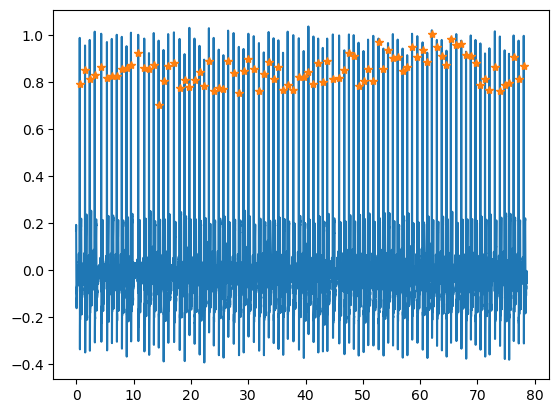

In [3]:
import pilottone as pt
mri_coils = np.arange(15, dtype=int)
sensing_coils = np.array([15, 16, 17], dtype=int)
coil_name = []

for clbl in hdr.acquisitionSystemInformation.coilLabel:
    coil_name.append(clbl.coilName)

coil_name = np.asarray(coil_name)

print(f"Coils to be used as sniffers: {coil_name[sensing_coils.astype(int)]}")

f0 = hdr.experimentalConditions.H1resonanceFrequency_Hz
df = 1/(dt*data.shape[0])

t_acq_start = acq_list[0].acquisition_time_stamp*2.5e-3 # [2.5ms] -> [s]
t_acq_end = acq_list[-1].acquisition_time_stamp*2.5e-3
time_acq = np.linspace(t_acq_start, t_acq_end, n_acq) # Interpolate for TR, as TR will not be a multiple of time resolution.
time_pt = time_acq - t_acq_start
samp_time_pt = time_acq[1] - time_acq[0]

ksp_measured = data[:,:,mri_coils]
ksp_sniffer  = data[:,:,sensing_coils]

## Process ECG waveform
ecg, _ = mrdhelper.waveforms_asarray(wf_list)
ecg_waveform = ecg['ecg_waveform']
ecg_waveform = pt.check_waveform_polarity(ecg_waveform, 0.5)*ecg_waveform
time_ecg = ecg['time_ecg'] - acq_list[0].acquisition_time_stamp*2.5e-3
ecg_trigs = ecg['ecg_trigs']
plt.figure()
plt.plot(time_ecg, ecg_waveform)
plt.plot(time_ecg[ecg_trigs==1], ecg_waveform[ecg_trigs==1], '*')


## PT correction

/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


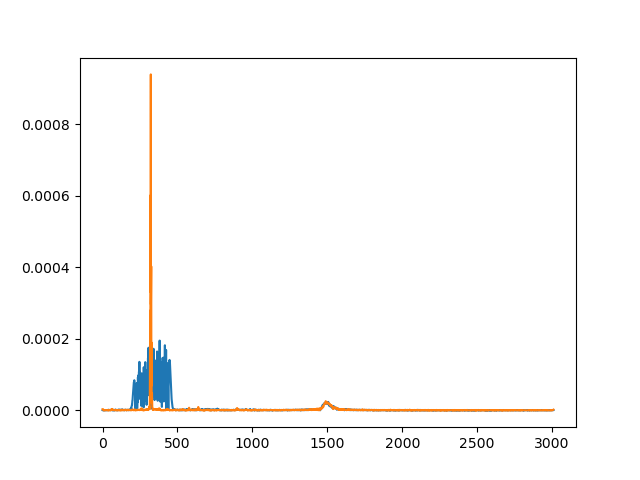

8.846664667129517


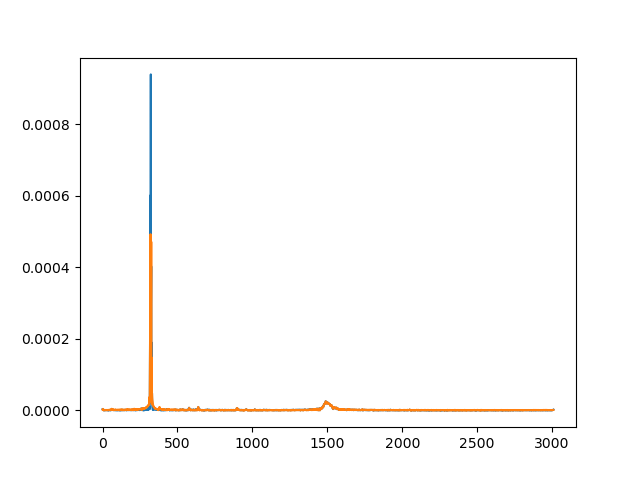

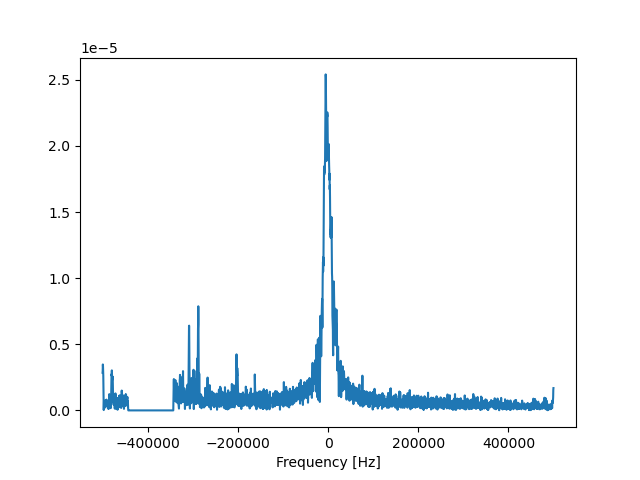

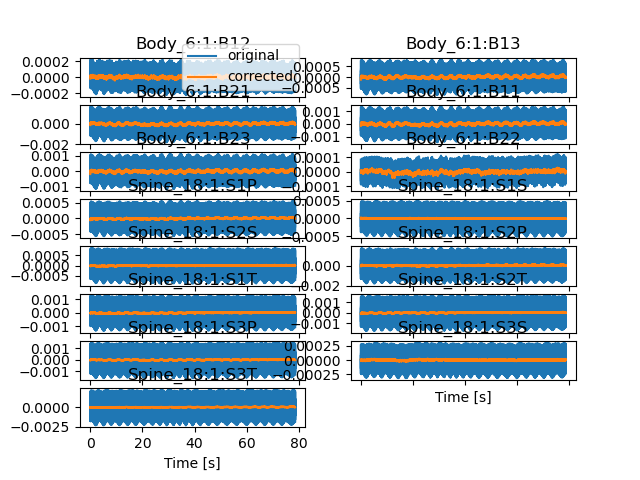

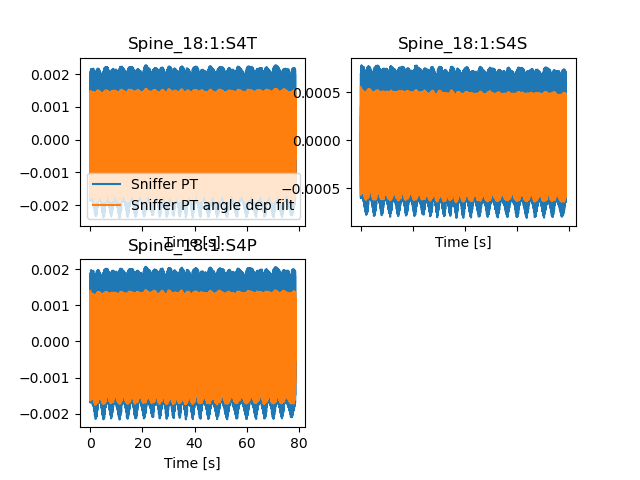

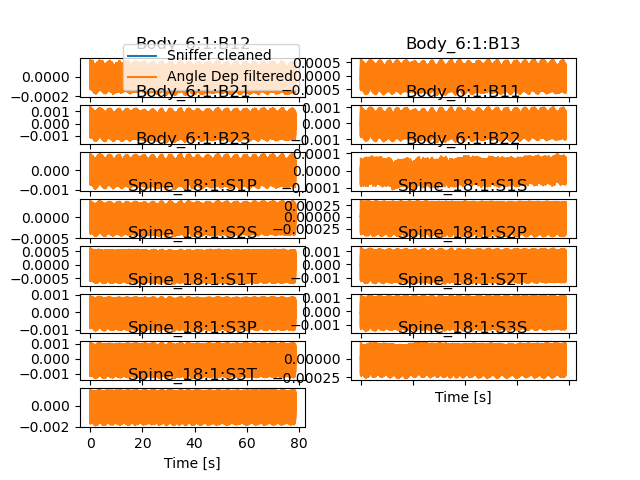

In [4]:
%matplotlib widget
import pilottone as pt

f_diff = f0 - f_pt

# ================================
# Demodulate any shifts
# ================================
phase_mod_rads = pt.calc_fovshift_phase(
    np.vstack((np.zeros((pre_discard, n_unique_angles)), kx)), 
    np.vstack((np.zeros((pre_discard, n_unique_angles)), ky)), 
    acq_list[0])
phase_mod_rads = [phase_mod_rads[:,ii%n_unique_angles] for ii in range(n_acq)]
phase_mod_rads = np.array(phase_mod_rads)[:, :].transpose()[:,:,None]

# Apply the negative of the phase
ksp_sniffer_  = ksp_sniffer*phase_mod_rads
ksp_measured_ = ksp_measured*phase_mod_rads

plt.figure()
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured[:,10,0])))
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.show()

fcorrmin = pt.find_freq_qifft(ksp_measured_[:,:,:], df, f_diff, 3e3, 4, (2))

ksp_window = np.ones(ksp_measured_.shape[0])
# ksp_window = ksp_window[nc:]
ksp_measured_ = ksp_measured_*ksp_window[:,None,None]
ksp_sniffer_ = ksp_sniffer_*ksp_window[:,None,None]

time_acq = np.arange(0, ksp_measured_.shape[0])*dt

ksp_ptsubbed_, pt_sig_fit = pt.est_dtft(time_acq, ksp_measured_, np.array([f_diff])-fcorrmin, ksp_window)
_, pt_sig_fit_sniffer = pt.est_dtft(time_acq, ksp_sniffer_, np.array([f_diff])-fcorrmin, ksp_window)

pt_sig_fit = np.abs(pt_sig_fit)
pt_sig_fit_sniffer = np.abs(pt_sig_fit_sniffer)
pt_sig = np.squeeze(pt_sig_fit - np.mean(pt_sig_fit, axis=1, keepdims=True))
pt_sig_sniffer = np.squeeze(pt_sig_fit_sniffer - np.mean(pt_sig_fit_sniffer, axis=1, keepdims=True))

plt.figure()
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_measured_[:,10,0])))
plt.plot(np.abs(pt.signal.to_hybrid_kspace(ksp_ptsubbed_[:,10,0])))
plt.show()

# Pilot tone cleanup?
pt_sig_clean = pt.sniffer_sub(pt_sig, pt_sig_sniffer)

pt.plot_multich_comparison(time_pt, (pt_sig, pt_sig_clean), coil_name[mri_coils], ('original', 'corrected'))

# Filter a bandwidth around the pilot tone frequency.
fbw = 100e3
freq_axis = ifftshift(np.fft.fftfreq(ksp_ptsubbed_.shape[0], dt))

ksp_win = tukey(2*ksp_ptsubbed_.shape[0], alpha=0.1)
ksp_win = ksp_win[(ksp_ptsubbed_.shape[0]):,None,None]
ksp_ptsubbed_ = ksp_ptsubbed_*ksp_win # kspace filtering to remove spike at the end of the acquisition

ptmdlflt = np.ones((ksp_ptsubbed_.shape[0]))
ptmdlflt[(freq_axis < (f_diff+fbw/2)) & (freq_axis > (f_diff-fbw/2))] = 0
ksp_ptsubbed_ = pt.signal.from_hybrid_kspace(ptmdlflt[:,None,None]*pt.signal.to_hybrid_kspace(ksp_ptsubbed_))

plt.figure()
plt.plot(freq_axis, np.abs(pt.signal.to_hybrid_kspace(ksp_ptsubbed_[:,10,0])))
plt.xlabel('Frequency [Hz]')
plt.show()

pt_sig_clean2 = pt.signal.angle_dependant_filtering(pt_sig, n_unique_angles)
pt_sig_sniffer_clean2 = pt.signal.angle_dependant_filtering(pt_sig_sniffer, n_unique_angles)

pt.plot_multich_comparison(time_pt, (pt_sig_sniffer, pt_sig_sniffer_clean2), coil_name[sensing_coils], ('Sniffer PT','Sniffer PT angle dep filt'))
pt.plot_multich_comparison(time_pt, (pt_sig_clean, pt_sig_clean2), coil_name[mri_coils], ('Sniffer cleaned', 'Angle Dep filtered'))


## QA and ECG PT Jitter

Rejection ratio for pt peaks is 1.11 percent.

Rejection ratio for derivative pt peaks is 2.25 percent.

Peak difference 303.1 ± 12.5
Derivative peak difference 137.3 ± 10.5
Number of ECG triggers: 90.
Number of PT triggers: 90.
Number of missed PT triggers: 0.
Number of extraneous PT triggers: 0.
Number of derivative PT triggers: 89.
Number of missed derivative PT triggers: 1.
Number of extraneous derivative PT triggers: 0.


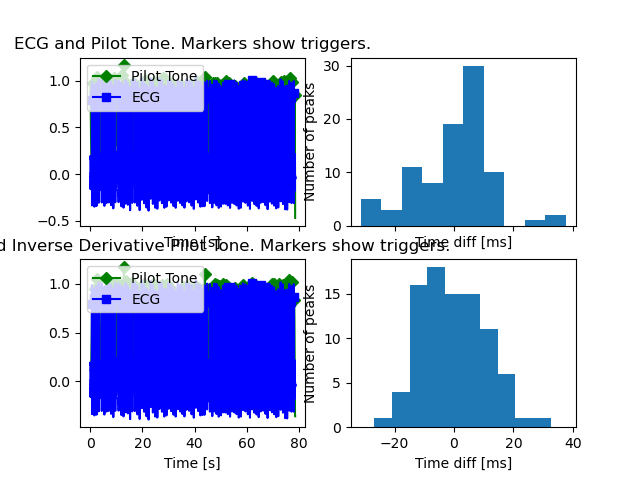

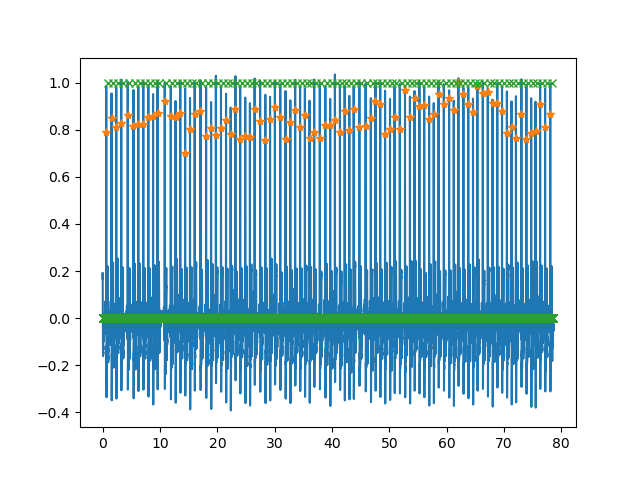

In [5]:
%matplotlib widget
import pilottone_ecg_jitter
importlib.reload(pilottone_ecg_jitter)
import pilottone
importlib.reload(pilottone.pt)
from pilottone_ecg_jitter import pt_ecg_jitter

from pilottone.pt import extract_triggers
f_samp = 1/samp_time_pt # [Hz]

pt_extract_params = {'golay_filter_len': 101,
                    'respiratory': {
                            'freq_start': 0.05,
                            'freq_stop': 0.9,
                            'corr_threshold': 0.9,
                            'corr_init_ch': -1,
                            'separation_method': 'sobi', # 'sobi', 'pca'
                    },
                    'cardiac': {
                                'freq_start': 1,
                                'freq_stop': 20,
                                'corr_threshold': 0.90,
                                'corr_init_ch': np.nonzero(coil_name == 'Body_6:1:B22')[0][0],                           
                                'separation_method': 'pca', # 'sobi', 'pca'

                    },
                    'debug': {
                        'selected_coils': [0,1],
                        'coil_legend': coil_name[mri_coils],
                        'show_plots': False
                    }
                }

sg_filter_len = 81

pt_respiratory, pt_cardiac = pt.extract_pilottone_navs(pt_sig_clean2, f_samp, pt_extract_params)

pt_cardiac_filtered = savgol_filter(pt_cardiac, sg_filter_len, 3, axis=0)
pt_cardiac_derivative = np.hstack((0, np.diff(pt_cardiac_filtered)/(time_pt[1] - time_pt[0])))
pt_cardiac_derivative[:20] = pt_cardiac_derivative[20]
pt_cardiac_derivative[-20:] = pt_cardiac_derivative[-20]
pt_cardiac_derivative -= np.percentile(pt_cardiac_derivative, 5)
pt_cardiac_derivative /= np.percentile(pt_cardiac_derivative, 99)

pt_cardiac_trigs = extract_triggers(time_pt, pt_cardiac, skip_time=0.6, prominence=0.5)
pt_derivative_trigs = extract_triggers(time_pt, pt_cardiac_derivative, skip_time=0.6, prominence=0.6)

_,_ = pt_ecg_jitter(time_pt, pt_cardiac, pt_cardiac_derivative,
                    time_ecg, ecg_waveform, 
                    pt_cardiac_trigs=pt_cardiac_trigs, pt_derivative_trigs=pt_derivative_trigs, ecg_trigs=ecg_trigs, 
                    skip_time=0.6, show_outputs=True)

## Save the waveforms into the original data

In [6]:
# Concat, and normalize pt waveforms.
import ctypes
dt_pt = (time_pt[1] - time_pt[0])
pt_wf_data = np.vstack((pt_respiratory, pt_cardiac, pt_cardiac_trigs, pt_cardiac_derivative, pt_derivative_trigs))
pt_wf_data = ((pt_wf_data/np.max(np.abs(pt_wf_data), axis=1, keepdims=True)*(2**31-1)) + 2**31).astype(np.uint32)

pt_wf = ismrmrd.waveform.Waveform.from_array(pt_wf_data)
pt_wf._head.sample_time_us = ctypes.c_float(dt_pt*1e6)
pt_wf._head.waveform_id = ctypes.c_uint16(PILOTTONE_WAVEFORM_ID)
pt_wf._head.time_stamp = acq_list[0].acquisition_time_stamp

with ismrmrd.Dataset(ismrmrd_data_fullpath) as dset:
    dset.append_waveform(pt_wf)

print('Done writing the waveform.')


Done writing the waveform.


# Save the PT subtracted k-space

Reading /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/noise/noise_meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz.h5...
There are 1842 acquisitions in the file. Reading...
Prewhitening the raw data...


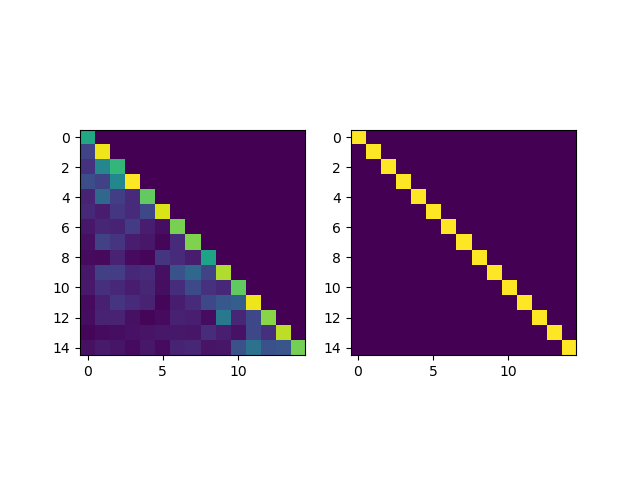

Saving to /server/home/btasdelen/MRI_DATA/pilottone/vol0912_20240626/raw/h5_proc/meas_MID00292_FID16401_pulseq2D_fire_spiralga_1500mV_24MHz_mdlsub.h5


/server/home/btasdelen/micromamba/envs/pilottone/lib/python3.10/site-packages/h5py/_hl/filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)


In [7]:

if cfg['saving']['save_model_subtracted']:
    from pathlib import Path
    import copy
    import pyfftw
    from editer import autopick_sensing_coils

    ksp_ptsubbed = ksp_ptsubbed_*np.conj(phase_mod_rads)

    # Read the noise data in
    print(f'Reading {ismrmrd_noise_fullpath}...')
    with ismrmrd.Dataset(ismrmrd_noise_fullpath) as dset_noise:
        n_cal_acq = dset_noise.number_of_acquisitions()
        print(f'There are {n_cal_acq} acquisitions in the file. Reading...')

        cal_list = []
        for ii in range(n_cal_acq):
            cal_list.append(dset_noise.read_acquisition(ii))

    noise_list = []

    for cal_ in cal_list:
        if cal_.is_flag_set(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
            noise_list.append(cal_.data)

    noise = np.transpose(np.asarray(noise_list), (1,0,2)).reshape((noise_list[0].shape[0], -1))[mri_coils,:]

    if cfg['pilottone']['prewhiten']:
        from reconstruction.coils import apply_prewhitening, calculate_prewhitening

        print('Prewhitening the raw data...')
        dmtx = calculate_prewhitening(noise)

        ksp_ptsubbed = apply_prewhitening(np.transpose(ksp_ptsubbed, (2,0,1)), dmtx).transpose((1,2,0))

        dmtx2 = calculate_prewhitening(apply_prewhitening(noise, dmtx))

        _,axs = plt.subplots(1,2)
        axs[0].imshow(np.abs(dmtx))
        axs[1].imshow(np.abs(dmtx2))
        plt.show()

    if cfg['pilottone']['discard_badcoils']:
        mri_coils2, _ = autopick_sensing_coils(ksp_measured, f_emi=f_diff, bw_emi=100e3, bw_sig=200e3, f_samp=1/dt, n_sensing=5)
        ksp_ptsubbed = ksp_ptsubbed[:,:,mri_coils2]
        mri_coils = mri_coils[mri_coils2]
        
    n_samp = ksp_ptsubbed.shape[0]

    if remove_os:
        ksp_ptsubbed = pyfftw.byte_align(ksp_ptsubbed)

        keepOS = np.concatenate([np.arange(n_samp // 4), np.arange(n_samp * 3 // 4, n_samp)])
        ifft_ = pyfftw.builders.ifft(ksp_ptsubbed, n=n_samp, axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
        ksp_ptsubbed = ifft_()

        fft_ = pyfftw.builders.fft(ksp_ptsubbed[keepOS, :, :], n=keepOS.shape[0], axis=0, threads=32, planner_effort='FFTW_ESTIMATE')
        ksp_ptsubbed = fft_()
        n_samp = n_samp // 2


    output_dir_fullpath = os.path.join(DATA_ROOT, DATA_DIR, 'raw', 'h5_proc')
    output_data_fullpath = os.path.join(output_dir_fullpath, f"{ismrmrd_data_fullpath.split('/')[-1][:-3]}_mdlsub.h5")
    print('Saving to ' + output_data_fullpath)

    Path.mkdir(Path(output_dir_fullpath), exist_ok=True)

    # Add EDITER parameters to XML header.
    new_hdr = copy.deepcopy(hdr)
    new_hdr.userParameters.userParameterString.append(ismrmrd.xsd.userParameterStringType('processing', 'ModelSubtraction'))
    new_hdr.acquisitionSystemInformation.coilLabel = [hdr.acquisitionSystemInformation.coilLabel[ch_i] for ch_i in mri_coils]
    new_hdr.acquisitionSystemInformation.receiverChannels = len(new_hdr.acquisitionSystemInformation.coilLabel)

    # Copy and fix acquisition objects
    new_acq_list = []

    for acq_i, acq_ in enumerate(acq_list):
        new_head = copy.deepcopy(acq_.getHead())
        new_head.active_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
        new_head.available_channels = len(new_hdr.acquisitionSystemInformation.coilLabel)
        if remove_os:
            new_head.number_of_samples = ksp_ptsubbed.shape[0]
            new_head.center_sample = pre_discard//2

        new_acq_list.append(ismrmrd.Acquisition(head=new_head, data=np.ascontiguousarray(ksp_ptsubbed[:,acq_i,:].squeeze().T.astype(np.complex64))))

    with ismrmrd.Dataset(output_data_fullpath, create_if_needed=True) as new_dset:
        for acq_ in new_acq_list:
            new_dset.append_acquisition(acq_)

        for wave_ in wf_list:
            new_dset.append_waveform(wave_)

        new_dset.append_waveform(pt_wf)

        new_dset.write_xml_header(ismrmrd.xsd.ToXML(new_hdr))